# Amazon Reviews Analysis

## Import Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

# Load cleaned data
df = pd.read_csv('/Users/william/Desktop/amazon case study/cleaned_sampled_reviews_mini.csv', on_bad_lines='skip', low_memory=False)

# Sample a fraction of the data
sample_fraction = 0.2
df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df = df.dropna(subset=["review_date"])

# Remove duplicates
df = df.drop_duplicates(subset="review_id")

In [22]:
# Size of our reduced dataset
df.shape

(1094610, 15)

## Exploratory Data Analysis

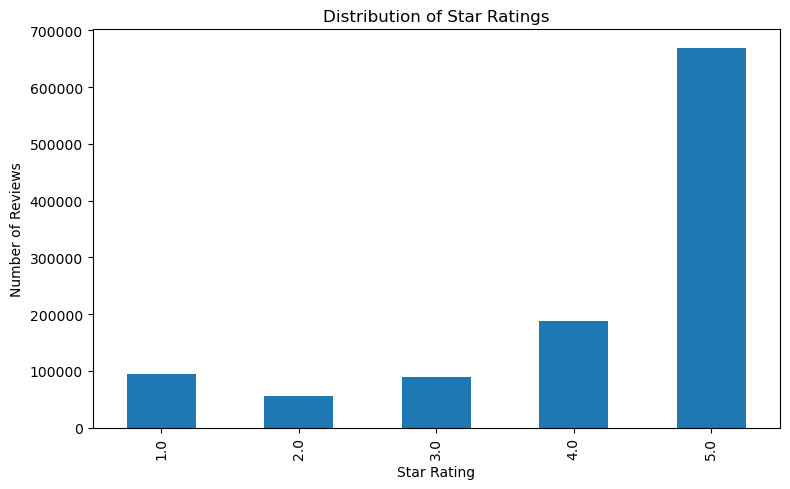

In [23]:
plt.figure(figsize=(8, 5))
df['star_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

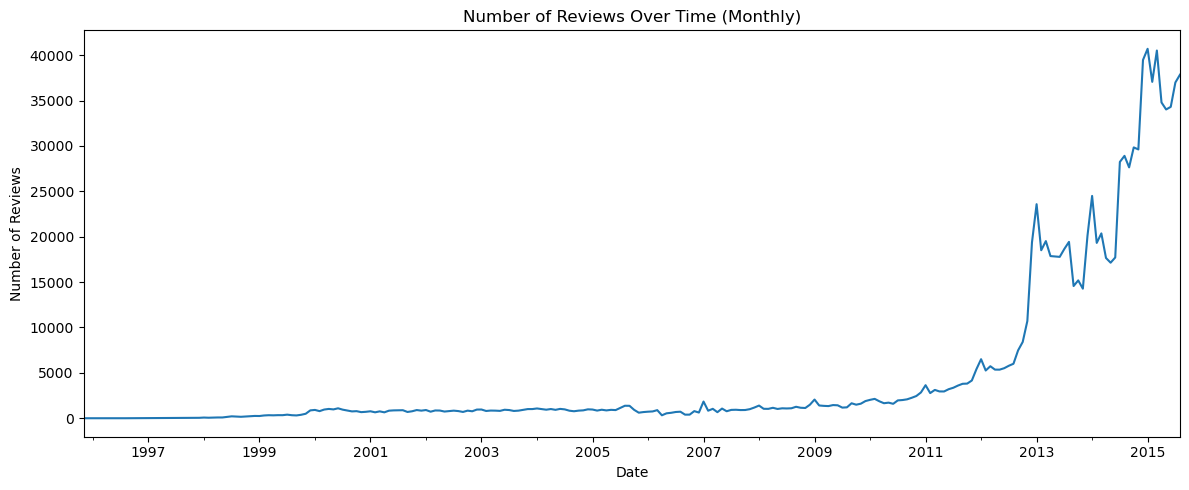

In [83]:
plt.figure(figsize=(12, 5))
df.set_index('review_date').resample('ME').size().plot()
plt.title('Number of Reviews Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

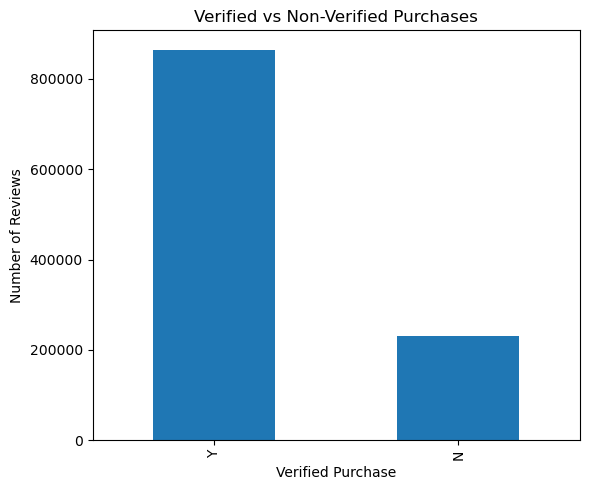

In [25]:
plt.figure(figsize=(6, 5))
df['verified_purchase'].value_counts().plot(kind='bar')
plt.title('Verified vs Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

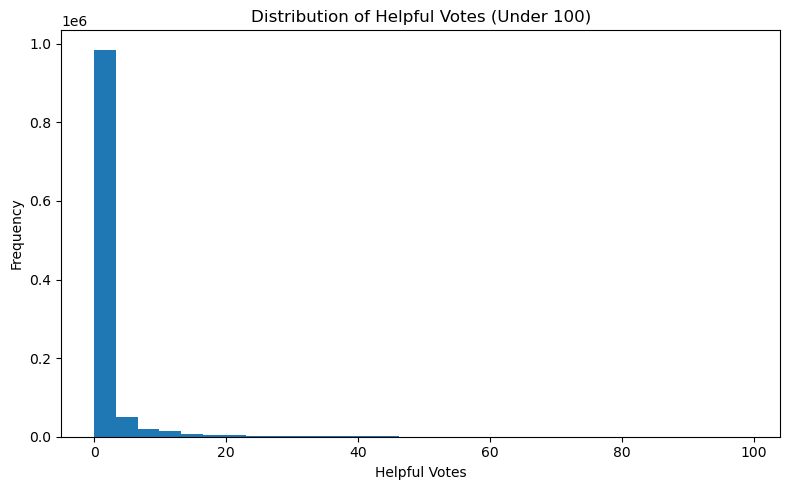

In [26]:
plt.figure(figsize=(8, 5))
df[df['helpful_votes'] < 100]['helpful_votes'].plot(kind='hist', bins=30)
plt.title('Distribution of Helpful Votes (Under 100)')
plt.xlabel('Helpful Votes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [27]:
reviews_per_customer = df['customer_id'].value_counts().reset_index()
reviews_per_customer.columns = ['customer_id', 'review_count']
reviews_per_customer.head()

,customer_id,review_count
0,50122160,223
1,50736950,96
2,18116317,93
3,52496677,89
4,50732546,84


## Feature Engineering

In [28]:
# Adding review length as a feature
df['review_length'] = df['review_body'].apply(lambda x: len(str(x).split()))

# Adding headline length as a feature
df['headline_length'] = df['review_headline'].apply(lambda x: len(str(x).split()))

# Adding the ratio of helpful votes as a feature
df['helpful_ratio'] = df.apply(lambda row: row['helpful_votes'] / row['total_votes']
                               if row['total_votes'] > 0 else 0, axis=1)

## Sentiment Analysis

In [29]:
sampled_reviews = df[['review_id', 'review_body', 'star_rating', 'helpful_ratio', 'headline_length', 'review_length']].copy()

def analyze_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

sampled_reviews['sentiment_score'] = sampled_reviews['review_body'].apply(analyze_sentiment)

def label_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

sampled_reviews['sentiment_label'] = sampled_reviews['sentiment_score'].apply(label_sentiment)
sampled_reviews['sentiment_label'].value_counts()

sentiment_label
Positive    807723
Neutral     225093
Negative     61794
Name: count, dtype: int64

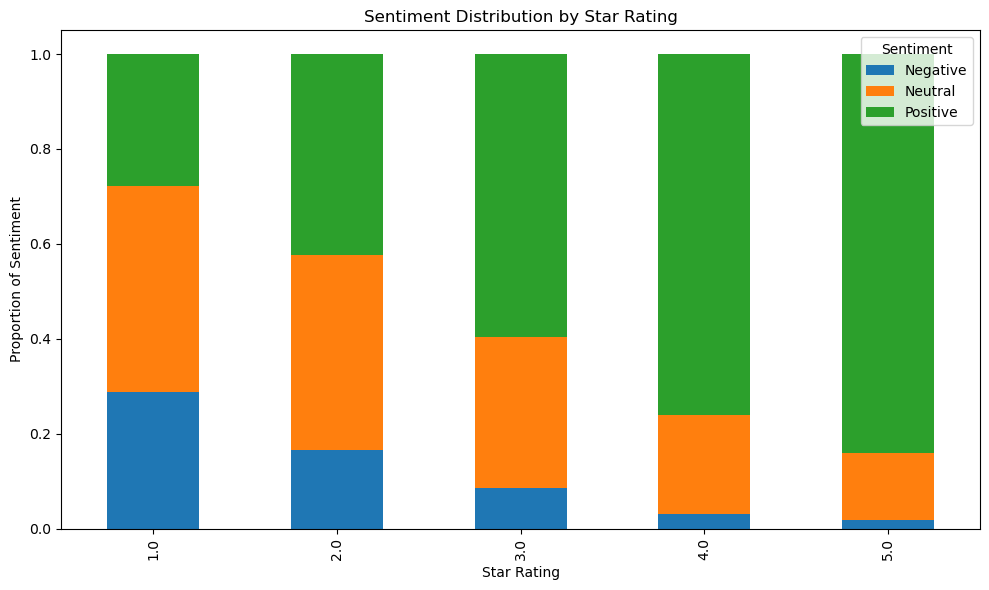

In [30]:
sentiment_vs_rating = sampled_reviews.groupby(['star_rating', 'sentiment_label']).size().unstack().fillna(0)
sentiment_vs_rating_pct = sentiment_vs_rating.div(sentiment_vs_rating.sum(axis=1), axis=0)

sentiment_vs_rating_pct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Proportion of Sentiment')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Predicting Review Rating

### Model 1: Logistic Regression

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.sparse as sp

# Create classifications for positive and negative reviews
sampled_reviews['review_rating'] = sampled_reviews['star_rating'].apply(lambda x: 'Positive' if x > 3 else 'Negative')

# Prepare features
model_data = sampled_reviews[['review_body', 'sentiment_score', 'review_length', 
                              'review_rating', 'helpful_ratio', 'headline_length']].dropna()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(model_data['review_body'])

# Scale numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(model_data[['sentiment_score', 'review_length', 'helpful_ratio', 'headline_length']])

# Combine features
X = sp.hstack([X_text, X_numeric_scaled])
y = model_data['review_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [74]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.75      0.54      0.63     71331
    Positive       0.88      0.95      0.92    257052

    accuracy                           0.86    328383
   macro avg       0.82      0.75      0.77    328383
weighted avg       0.85      0.86      0.85    328383



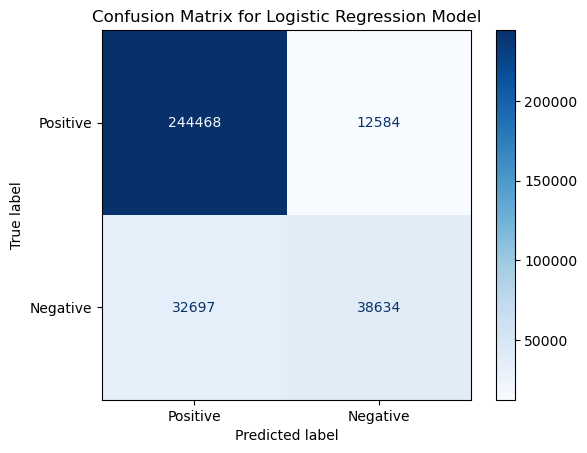

In [75]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

### Model 2: Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Train model (Decision Tree)
modeldt = DecisionTreeClassifier(max_depth=5, random_state=42)
modeldt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = modeldt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

    Negative       0.65      0.36      0.46     71331
    Positive       0.84      0.95      0.89    257052

    accuracy                           0.82    328383
   macro avg       0.75      0.65      0.68    328383
weighted avg       0.80      0.82      0.80    328383



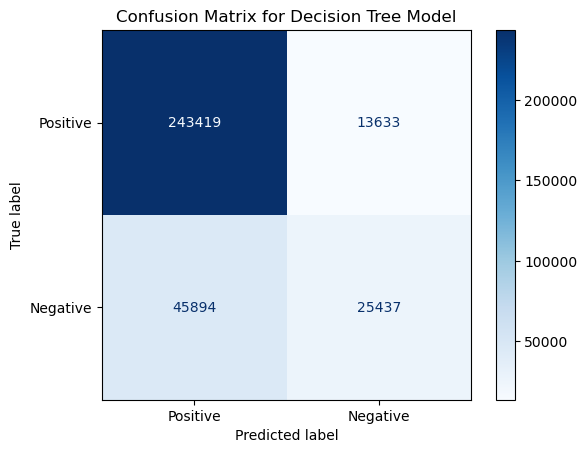

In [77]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt, labels=['Positive', 'Negative'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

Notice that there are a lot more positive reviews in the data than negative reviews (by an order of magnitude). Try training another model but on a more even dataset.

In [81]:
# Get indices of each class
positive_idx = np.where(y == 'Positive')[0]
negative_idx = np.where(y == 'Negative')[0]

# Randomly reduce the number of positive reviews to the same number as negative reviews
np.random.seed(42)
n_pos = int(len(negative_idx))
positive_idx_sampled = np.random.choice(positive_idx, size=n_pos, replace=False)

# Combine sampled indices
selected_idx = np.concatenate([positive_idx_sampled, negative_idx])

# Convert X to CSR format so it's subscriptable
X = X.tocsr()

# Reset y index to match X row numbers
y = pd.Series(y).reset_index(drop=True)

# Subset X and y
X = X[selected_idx]
y = y[selected_idx]

# Train-test split
X_train, X_test_new, y_train, y_test_new = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train model
modelnew = LogisticRegression(max_iter=1000)
modelnew.fit(X_train, y_train)

# Predict and evaluate
y_pred_new = modelnew.predict(X_test_new)
print(classification_report(y_test_new, y_pred_new))

# Predict and evaluate on old test data
y_pred_old = modelnew.predict(X_test)
print(classification_report(y_test, y_pred_old))

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81     71332
    Positive       0.82      0.80      0.81     71331

    accuracy                           0.81    142663
   macro avg       0.81      0.81      0.81    142663
weighted avg       0.81      0.81      0.81    142663

              precision    recall  f1-score   support

    Negative       0.53      0.82      0.65     71331
    Positive       0.94      0.80      0.86    257052

    accuracy                           0.80    328383
   macro avg       0.74      0.81      0.76    328383
weighted avg       0.85      0.80      0.82    328383



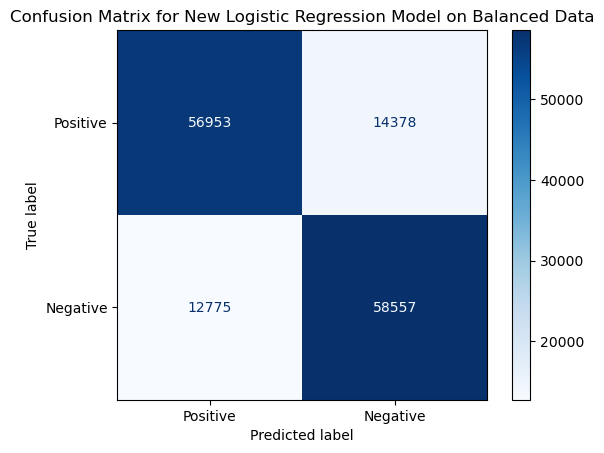

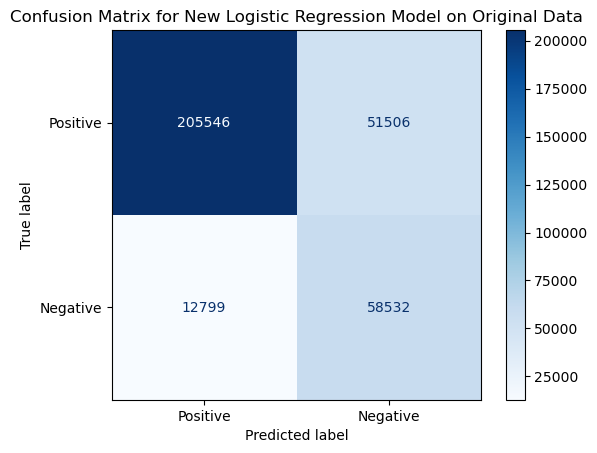

In [82]:
# Confusion matrix with balanced data
cm = confusion_matrix(y_test_new, y_pred_new, labels=['Positive', 'Negative'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for New Logistic Regression Model on Balanced Data")
plt.show()

# Confusion matrix with original data
cm = confusion_matrix(y_test, y_pred_old, labels=['Positive', 'Negative'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for New Logistic Regression Model on Original Data")
plt.show()

### Summary

Logistic regression had the highest overall accuracy (86%) but struggled to identify negative reviews due to relative low number of negative reviews.

Decision tree models overall had lower performance than logistic regression models, with even worse performance in detecting negative reviews.

Adjusted logistic regression trained on a more balanced dataset offered better performance on detecting negative sentiment, making it more useful for pinpointing customer dissatisfaction.